In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

# Model definition and parameters
model = pybamm.lithium_ion.SPM(
    options={
        "cell geometry": "pouch",
        "current collector": "potential pair",
        "dimensionality": 2,
        "thermal": "x-lumped",
    },
)


# Define parameters using PyBaMM's parameter interface
E_C = pybamm.Parameter("Positive electrode Young modulus [Pa]")
E_A = pybamm.Parameter("Negative electrode Young modulus [Pa]")
a_C = pybamm.Parameter("Positive electrode expansion coefficient")
a_A = pybamm.Parameter("Negative electrode expansion coefficient")
v_A = pybamm.Parameter("Positive electrode Poisson ratio")
v_C = pybamm.Parameter("Negative electrode Poisson ratio")
t_C = pybamm.Parameter("Positive electrode thickness [m]")
t_A = pybamm.Parameter("Negative electrode thickness [m]")
U = pybamm.Parameter("Total thickness relaxation [m]") #This is the total thickness variation. Set to 0 for a battery clamped when fully discharged (stochiometry of anode = 0).
N = pybamm.Parameter("Number of layers") 


# Set parameter values
parameter_values = pybamm.ParameterValues("Marquis2019")

parameter_values.update({"Positive electrode Young modulus [Pa]": 10**9}, check_already_exists=False)
parameter_values.update({"Negative electrode Young modulus [Pa]": 10**9}, check_already_exists=False)
parameter_values.update({"Positive electrode expansion coefficient": 0}, check_already_exists=False)
parameter_values.update({"Negative electrode expansion coefficient": 13/300}, check_already_exists=False)
parameter_values.update({"Negative electrode Poisson ratio": 0.2}, check_already_exists=False)
parameter_values.update({"Positive electrode Poisson ratio": 0.2}, check_already_exists=False)
parameter_values.update({"Number of layers": pybamm.Scalar(10)}, check_already_exists=False)
parameter_values.update({"Total thickness relaxation [m]": pybamm.Scalar(0)}, check_already_exists=False)

In [2]:
parameter_values["Positive current collector thickness [m]"] = 1e-05
parameter_values["Negative current collector thickness [m]"] = 1e-05


Now we define the mathematica equations from the paper:

In [3]:
# Expansion: we include an ad-hoc prediction of the swelling based on experimental data.
# The anode swells up to 13% in volume, 4.4% in strain. The cathode strain is smaller, we assume it to be 0.
#These need to be correctly parametrised.

def swelling_A(stoc):
    return a_A * stoc

def swelling_C(stoc):
    return a_C * stoc

#this is the displacement in the unit cell
du = U/N


# Define custom stress functions using PyBaMM expressions

def sigma_xx(alpha_A, alpha_C):
    return (du - alpha_A * ((1 + v_A)/(1-v_A))*t_A - alpha_C * ((1 + v_C)/(1-v_C))*t_C)/(((1 + v_A)*(1-2 * v_A)*t_A)/((1-v_A)*E_A)+((1 + v_C)*(1-2 * v_C)*t_C)/((1-v_C)*E_C))

def sigma_A_yy_zz(alpha_A, alpha_C):
    return (v_A/(1-v_A)) * sigma_xx(alpha_A, alpha_C) - (E_A/(1-v_A)) * alpha_A

def sigma_C_yy_zz(alpha_A, alpha_C):
    return (v_C/(1-v_C)) * sigma_xx(alpha_A, alpha_C) - (E_C/(1-v_C)) * alpha_C



In [4]:
# Retrieve stoichiometry from model variables
x_p = model.variables['Positive electrode stoichiometry']
x_n = model.variables['Negative electrode stoichiometry']

# Register stress variables
model.variables["Negative electrode in-plane stress (yy,zz) [Pa]"] = sigma_A_yy_zz(swelling_A(x_p), swelling_C(x_n))
model.variables["Positive electrode in-plane stress (yy,zz) [Pa]"] = sigma_C_yy_zz(swelling_A(x_p), swelling_C(x_n))
model.variables["Negative electrode through-cell stress xx [Pa]"] = sigma_xx(swelling_A(x_p), swelling_C(x_n))
model.variables["Positive electrode through-cell stress xx [Pa]"] = sigma_xx(swelling_A(x_p), swelling_C(x_n))
model.variables["Positive electrode expansion strain"] = swelling_C(x_n)
model.variables["Negative electrode expansion strain"] = swelling_A(x_p)





In [5]:

# Setup solver and simulation
solver = pybamm.CasadiSolver(atol=1e-6, rtol=1e-3, root_tol=1e-3, mode="safe")

experiment = pybamm.Experiment(["Discharge at 2C for 40 minutes"])


sim = pybamm.Simulation(
    model, experiment=experiment, parameter_values=parameter_values, solver=solver
)

# Solve the model
sol = sim.solve()

2024-04-23 16:39:09.049 - [WARNING] callbacks.on_experiment_infeasible(231): 

	Experiment is infeasible: 'event: Minimum voltage [V]' was triggered during 'Discharge at 2C for 40 minutes'. The returned solution only contains up to step 1 of cycle 1. 


In [6]:
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': 'cm'  # Short for Computer Modern, the default LaTeX font
})

def plot(solution,component, t):
    # Mesh for plotting
    L_y = parameter_values.evaluate(pybamm.Parameter("Electrode width [m]"))
    L_z = parameter_values.evaluate(pybamm.Parameter("Electrode height [m]"))
    y_plot = np.linspace(0, L_y, 101)
    z_plot = np.linspace(0, L_z, 101)
    
    # Evaluate stress and expansion variables at the given time
    plot_array = np.array(solution[component](y=y_plot, z=z_plot, t=t)).T

    # Plot the contour
    plt.figure(figsize=(3, 2), dpi=300)
    contour = plt.contourf(y_plot, z_plot,  plot_array, levels=100, cmap='viridis')  # Using the 'viridis' colormap
    plt.colorbar(contour)
    plt.xlabel(r"$y$ [m]")
    plt.ylabel(r"$z$ [m]")
    plt.show()

    

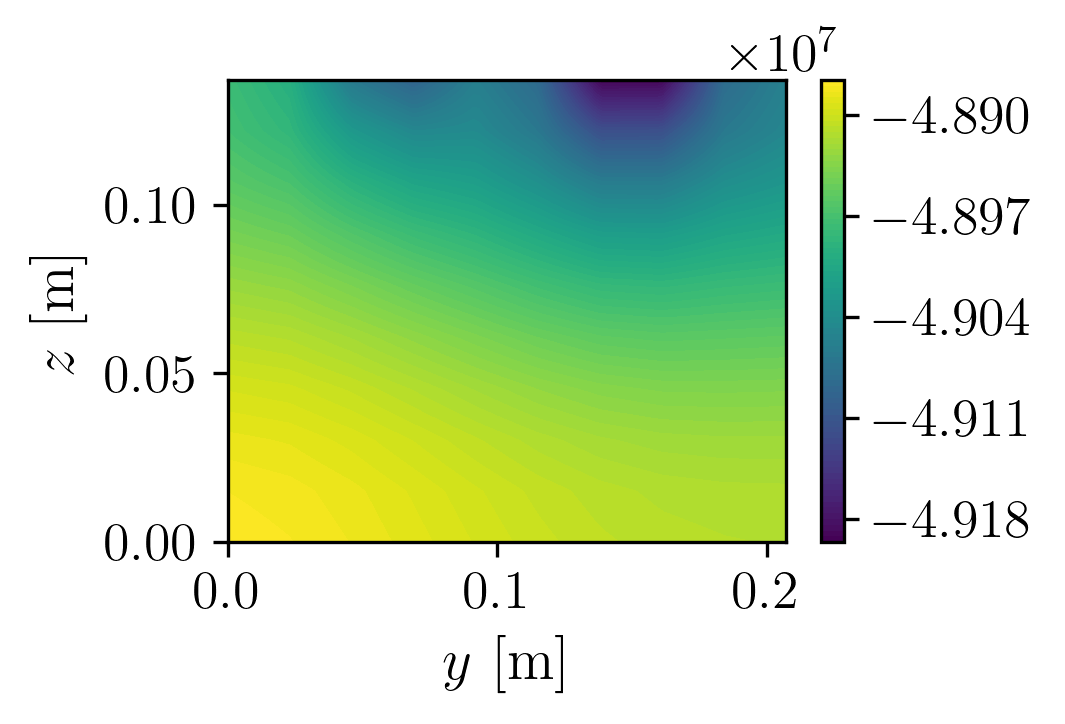

In [40]:
t=60*15

# Mesh for plotting
L_y = parameter_values.evaluate(pybamm.Parameter("Electrode width [m]"))
L_z = parameter_values.evaluate(pybamm.Parameter("Electrode height [m]"))
y_plot = np.linspace(0, L_y, 101)
z_plot = np.linspace(0, L_z, 101)
    
# Evaluate stress and expansion variables at the given time
plot_array = np.array(sol["Negative electrode in-plane stress (yy,zz) [Pa]"](y=y_plot, z=z_plot, t=t)).T

# Plot the contour
plt.figure(figsize=(3, 2), dpi=300)
contour = plt.contourf(y_plot, z_plot,  plot_array, levels=100, cmap='viridis')  # Using the 'viridis' colormap
plt.colorbar(contour,ticks=np.linspace(-4.89*10**7,-4.918*10**7,5))
plt.xlabel(r"$y$ [m]")
plt.ylabel(r"$z$ [m]")
plt.show()


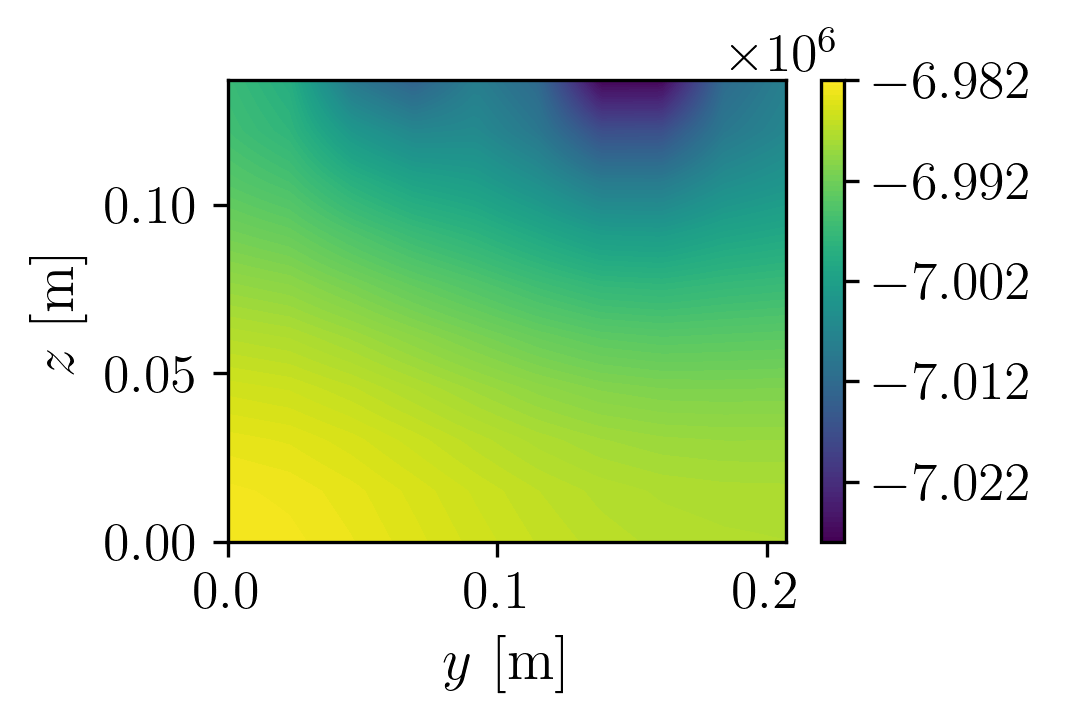

In [41]:
t=60*15

# Mesh for plotting
L_y = parameter_values.evaluate(pybamm.Parameter("Electrode width [m]"))
L_z = parameter_values.evaluate(pybamm.Parameter("Electrode height [m]"))
y_plot = np.linspace(0, L_y, 101)
z_plot = np.linspace(0, L_z, 101)
    
# Evaluate stress and expansion variables at the given time
plot_array = np.array(sol["Positive electrode in-plane stress (yy,zz) [Pa]"](y=y_plot, z=z_plot, t=t)).T

# Plot the contour
plt.figure(figsize=(3, 2), dpi=300)
contour = plt.contourf(y_plot, z_plot,  plot_array, levels=100, cmap='viridis')  # Using the 'viridis' colormap
plt.colorbar(contour,ticks=np.linspace(-7.022*10**6,-6.982*10**6,5))
plt.xlabel(r"$y$ [m]")
plt.ylabel(r"$z$ [m]")
plt.show()

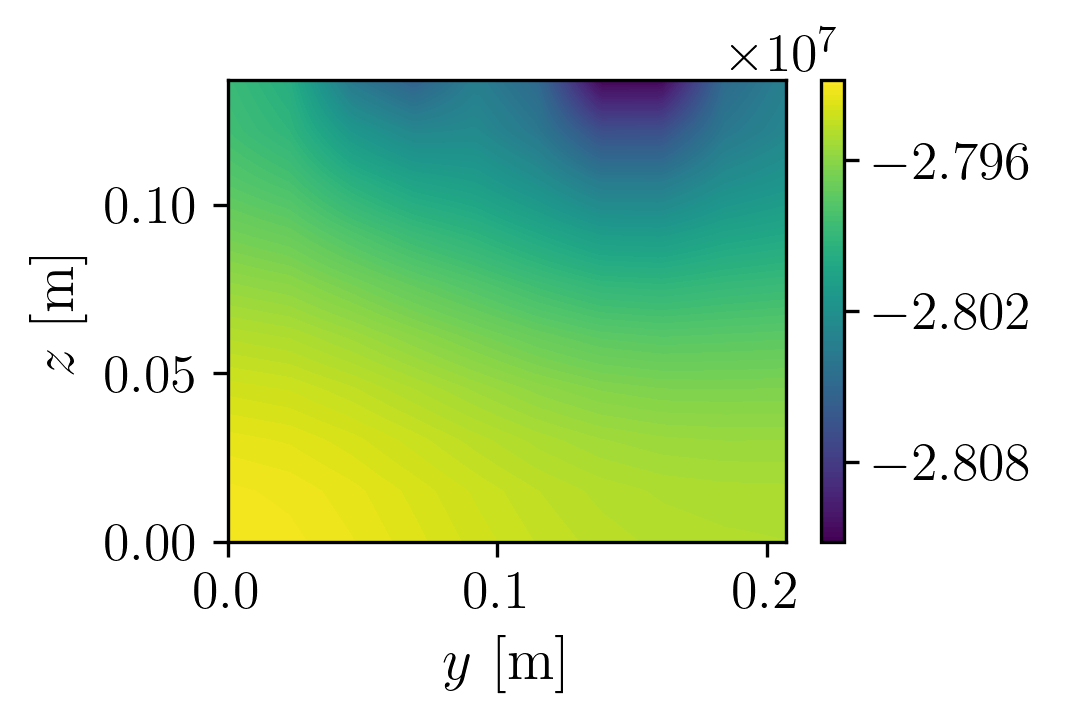

In [47]:
t=60*15

# Mesh for plotting
L_y = parameter_values.evaluate(pybamm.Parameter("Electrode width [m]"))
L_z = parameter_values.evaluate(pybamm.Parameter("Electrode height [m]"))
y_plot = np.linspace(0, L_y, 101)
z_plot = np.linspace(0, L_z, 101)
    
# Evaluate stress and expansion variables at the given time
plot_array = np.array(sol["Negative electrode through-cell stress xx [Pa]"](y=y_plot, z=z_plot, t=t)).T

# Plot the contour
plt.figure(figsize=(3, 2), dpi=300)
contour = plt.contourf(y_plot, z_plot,  plot_array, levels=100, cmap='viridis')  # Using the 'viridis' colormap
plt.colorbar(contour,ticks=np.linspace(-2.79*10**7,-2.814*10**7,5))
plt.xlabel(r"$y$ [m]")
plt.ylabel(r"$z$ [m]")
plt.show()


Text(0, 0.5, 'Through-cell stress [Pa]')

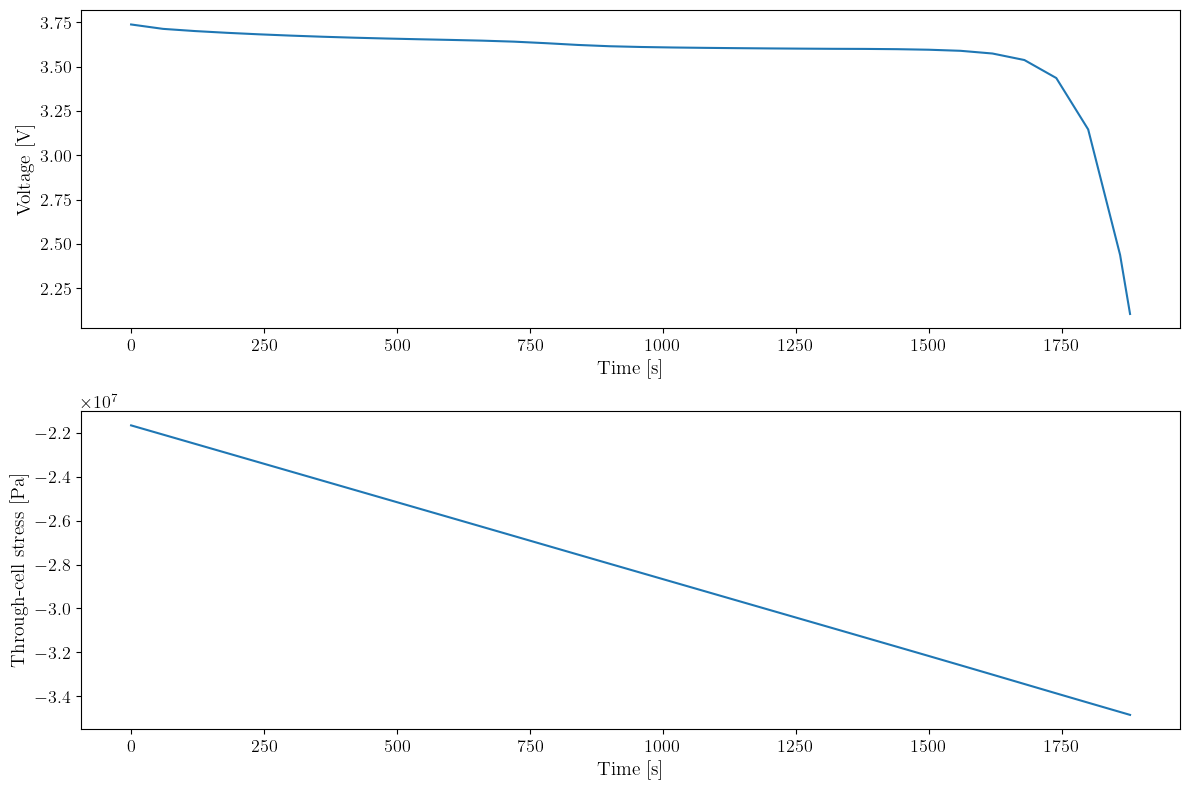

In [10]:
import matplotlib.pyplot as plt

plt.rc('axes', labelsize=14)  
plt.rc('xtick', labelsize=13)    
plt.rc('ytick', labelsize=13)  
plt.rc('legend', fontsize=13)   

fig, ax = plt.subplots(2, figsize=(12, 8), tight_layout=True)

ax[0].plot(
    sol["Time [s]"].entries, 
    sol["Terminal voltage [V]"].entries,
    label=sol.all_models[0].name
)    
ax[1].plot(
    sol["Time [s]"].entries, 
    sol["Positive electrode through-cell stress xx [Pa]"].entries[4,4],
    label=sol.all_models[0].name
)        

ax[0].set_xlabel("Time [s]")    
ax[0].set_ylabel("Voltage [V]")  
ax[1].set_xlabel("Time [s]")    
ax[1].set_ylabel("Through-cell stress [Pa]")


In [11]:
60*15

900

In [12]:
# Define plotting function
def plot(solution, t):
    # Post-process variables
    rhoP = solution["Average positive particle stoichiometry"]
    rhoN = solution["Average negative particle stoichiometry"]

    # Mesh for plotting
    L_y = parameter_values["Electrode width [m]"]
    L_z = parameter_values["Electrode height [m]"]
    y_plot = np.linspace(0, L_y, 41)
    z_plot = np.linspace(0, L_z, 41)
    
    # Create figure with subplots arranged horizontally
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Negative current collector potential
    phi_s_cn_plot = ax1.pcolormesh(
        y_plot, z_plot, rhoP(y=y_plot, z=z_plot, t=t).T, shading="gouraud"
    )
    ax1.set_xlabel(r"$y$ [m]")
    ax1.set_ylabel(r"$z$ [m]")
    ax1.set_title(r"$\rho_p$")
    fig.colorbar(phi_s_cn_plot, ax=ax1)

    # Positive current collector potential
    phi_s_cp_plot = ax2.pcolormesh(
        y_plot, z_plot, rhoN(y=y_plot, z=z_plot, t=t).T, shading="gouraud"
    )
    ax2.set_xlabel(r"$y$ [m]")
    ax2.set_ylabel(r"$z$ [m]")
    ax2.set_title(r"$\rho_n$")
    fig.colorbar(phi_s_cp_plot, ax=ax2)
    
    # Adjust layout to fit the subplots neatly
    plt.tight_layout()
    plt.show()



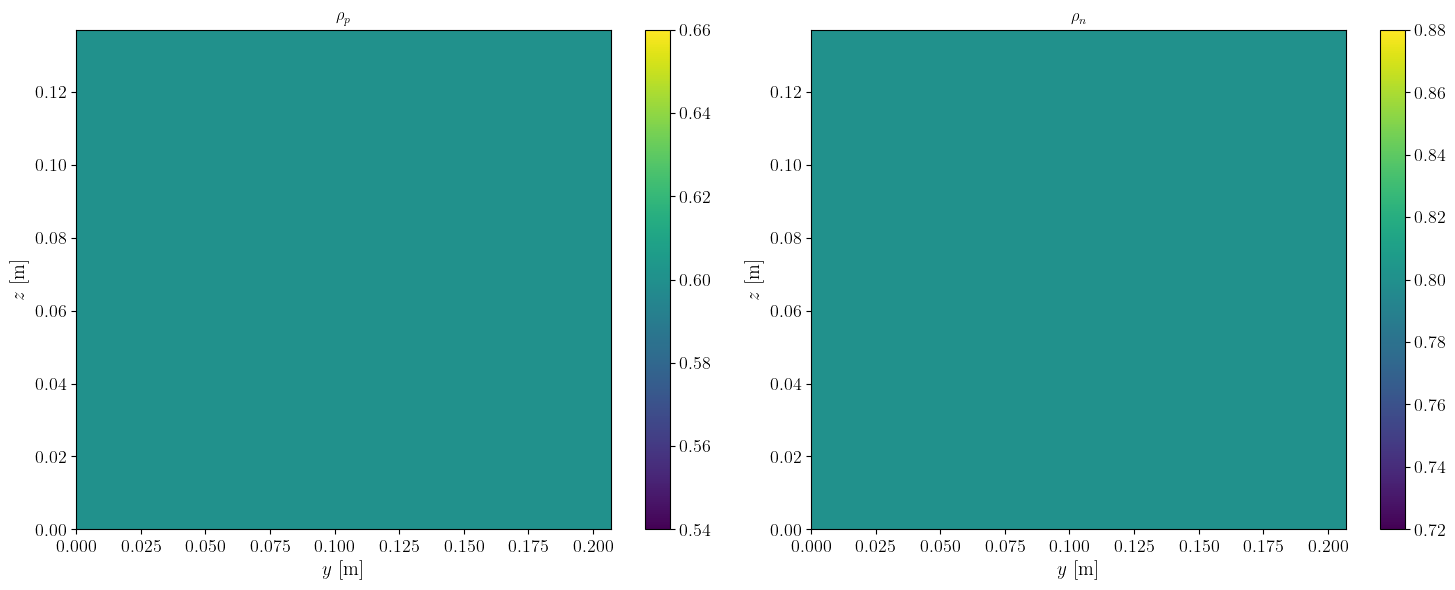

In [13]:
plot(sol, 0)

In [14]:
sol["Positive electrode in-plane stress (yy,zz) [Pa]"].entries

array([[[-5416666.66666667, -5520619.04316566, -5624663.72219542, ...,
         -8570415.4477042 , -8677389.982922  , -8710591.68082497],
        [-5416666.66666667, -5520654.34323162, -5624732.40239058, ...,
         -8570524.45807669, -8677439.24934896, -8710629.73579068],
        [-5416666.66666667, -5520740.80421402, -5624900.04437593, ...,
         -8570759.77638275, -8677541.44391418, -8710706.96655747],
        ...,
        [-5416666.66666667, -5521790.61052406, -5626932.12542329, ...,
         -8573226.46239455, -8678562.03686212, -8711458.8757305 ],
        [-5416666.66666667, -5521999.94351846, -5627332.16534292, ...,
         -8573652.21600696, -8678734.93966393, -8711585.01116759],
        [-5416666.66666667, -5522099.31549498, -5627519.43801087, ...,
         -8573833.41898329, -8678807.55602593, -8711637.36488764]],

       [[-5416666.66666667, -5520647.39058153, -5624719.31378635, ...,
         -8570519.67220752, -8677437.38713544, -8710628.48628127],
        [-5416666.6

In [15]:
sol["Positive electrode in-plane stress (yy,zz) [Pa]"](0.)

array([[-5416666.66666667, -5416666.66666667, -5416666.66666667,
        -5416666.66666667, -5416666.66666667, -5416666.66666667,
        -5416666.66666667, -5416666.66666667, -5416666.66666667,
        -5416666.66666667],
       [-5416666.66666667, -5416666.66666667, -5416666.66666667,
        -5416666.66666667, -5416666.66666667, -5416666.66666667,
        -5416666.66666667, -5416666.66666667, -5416666.66666667,
        -5416666.66666667],
       [-5416666.66666667, -5416666.66666667, -5416666.66666667,
        -5416666.66666667, -5416666.66666667, -5416666.66666667,
        -5416666.66666667, -5416666.66666667, -5416666.66666667,
        -5416666.66666667],
       [-5416666.66666667, -5416666.66666667, -5416666.66666667,
        -5416666.66666667, -5416666.66666667, -5416666.66666667,
        -5416666.66666667, -5416666.66666667, -5416666.66666667,
        -5416666.66666667],
       [-5416666.66666667, -5416666.66666667, -5416666.66666667,
        -5416666.66666667, -5416666.6666666

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming alpha, rhoN, concentration functions are defined as per your previous code

time_t=15*60

# Generate a grid of y and z values
y = np.linspace(0, 0.207, 100)
z = np.linspace(0, 0.137, 100)
Y, Z = np.meshgrid(y, z)

# Initialize an empty array for Ff with the same shape as Y and Z
FC = np.zeros_like(Y)

# Iterate over each element in Y and Z
for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        # Call the alpha function for each y, z pair and store the result in Ff
        FC[i, j] = sol["Positive electrode in-plane stress (yy,zz) [Pa]"](y=Y[i, j],z= Z[i, j], t = time_t)


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming alpha, rhoN, concentration functions are defined as per your previous code
time_t=15*60

# Generate a grid of y and z values
y = np.linspace(0, 0.207, 100)
z = np.linspace(0, 0.137, 100)
Y, Z = np.meshgrid(y, z)

# Initialize an empty array for Ff with the same shape as Y and Z
FA = np.zeros_like(Y)

# Iterate over each element in Y and Z
for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        # Call the alpha function for each y, z pair and store the result in Ff
        FA[i, j] = sol["Negative electrode in-plane stress (yy,zz) [Pa]"](y=Y[i, j],z= Z[i, j], t = time_t)

In [18]:
from scipy.ndimage import gaussian_filter

# Compute the gradient of Ff
grad_FC_y, grad_FC_z = np.gradient(FC, y, z, edge_order=2)

# Smooth the gradients
grad_FC_y_smooth = gaussian_filter(grad_FC_y, sigma=3)  # Adjust sigma as needed
grad_FC_z_smooth = gaussian_filter(grad_FC_z, sigma=3)  # Adjust sigma as needed

# Compute the gradient of Ff
grad_FA_y, grad_FA_z = np.gradient(FA, y, z, edge_order=2)

# Smooth the gradients
grad_FA_y_smooth = gaussian_filter(grad_FA_y, sigma=3)  # Adjust sigma as needed
grad_FA_z_smooth = gaussian_filter(grad_FA_z, sigma=3)  # Adjust sigma as needed


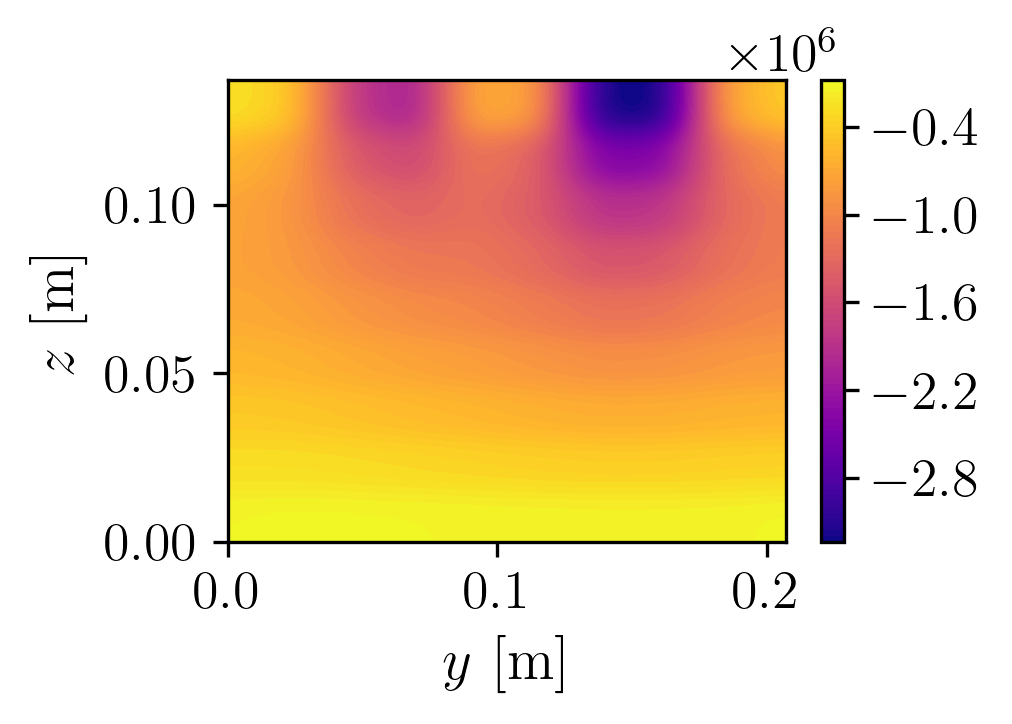

In [51]:
# Plot the contour
plt.figure(figsize=(3, 2), dpi=300)
contour = plt.contourf(Y, Z,  grad_FA_y_smooth, levels=100, cmap='plasma')  # Using the 'viridis' colormap
plt.colorbar(contour,ticks = np.linspace(-0.4 * 10 **6,-2.8 * 10 **6,5))
plt.xlabel(r"$y$ [m]")
plt.ylabel(r"$z$ [m]")
plt.show()

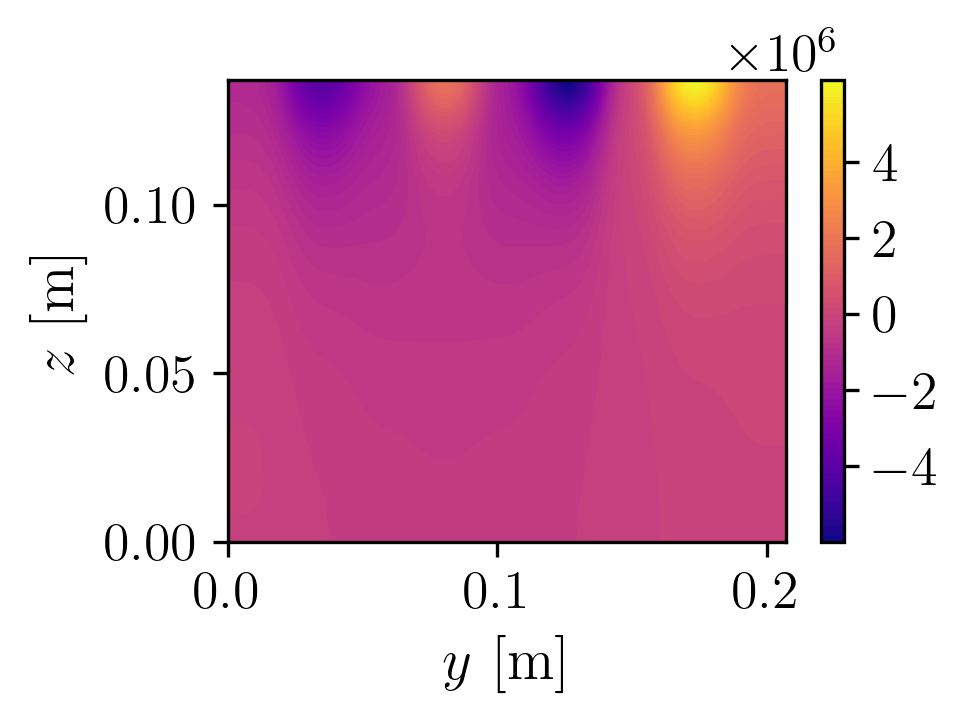

In [53]:
# Plot the contour
plt.figure(figsize=(3, 2), dpi=300)
contour = plt.contourf(Y, Z,  grad_FA_z_smooth, levels=100, cmap='plasma')  # Using the 'viridis' colormap
plt.colorbar(contour,ticks = np.linspace(-4 * 10 **6,4 * 10 **6,5))
plt.xlabel(r"$y$ [m]")
plt.ylabel(r"$z$ [m]")
plt.show()